<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

# Measurement Error Mitigation

* **Last Updated:** April 29, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2

## Introduction

The measurement calibration is used to mitigate measurement errors. 
The main idea is to prepare all $2^n$ basis input states and compute the probability of measuring counts in the other basis states. 
From these calibrations, it is possible to correct the average results of another experiment of interest. This notebook gives examples for how to use the ``ignis.mitigation.measurement`` module.

In [1]:
# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

## 3 Qubit Example of the Calibration Matrices

Assume that we would like to generate a calibration matrix for the 3 qubits Q2, Q3 and Q4 in a 5-qubit Quantum Register [Q0,Q1,Q2,Q3,Q4]. 

Since we have 3 qubits, there are $2^3=8$ possible quantum states.

## Generating Measurement Calibration Circuits

First, we generate a list of measurement calibration circuits for the full Hilbert space. 
Each circuit creates a basis state. 
If there are $n=3$ qubits, then we get $2^3=8$ calibration circuits.

The following function **complete_meas_cal** returns a list **meas_calibs** of QuantumCircuit objects containing the calibration circuits, 
and a list **state_labels** of the calibration state labels.

The input to this function can be given in one of the following three forms:

- **qubit_list:** A list of qubits to perform the measurement correction on, or:
- **qr (QuantumRegister):** A quantum register, or:
- **cr (ClassicalRegister):** A classical register.

In addition, one can provide a string **circlabel**, which is added at the beginning of the circuit names for unique identification.

For example, in our case, the input is a 5-qubit QuantumRegister containing the qubits Q2,Q3,Q4:

In [2]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[2,3,4], qr=qr, circlabel='mcal')

Print the $2^3=8$ state labels (for the 3 qubits Q2,Q3,Q4):

In [3]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

## Computing the Calibration Matrix

If we do not apply any noise, then the calibration matrix is expected to be the $8 \times 8$ identity matrix.

In [4]:
# Execute the calibration circuits without noise
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [5]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Assume that we apply some noise model from Qiskit Aer to the 5 qubits, 
then the calibration matrix will have most of its mass on the main diagonal, with some additional 'noise'.

Alternatively, we can execute the calibration circuits using IBMQ provider.

In [6]:
# Generate a noise model for the 5 qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

In [7]:
# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

In [8]:
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.729 0.204 0.212 0.052 0.2   0.056 0.064 0.022]
 [0.088 0.614 0.018 0.166 0.028 0.166 0.009 0.044]
 [0.081 0.024 0.619 0.178 0.028 0.005 0.151 0.044]
 [0.005 0.064 0.051 0.516 0.003 0.007 0.016 0.139]
 [0.074 0.013 0.021 0.003 0.592 0.18  0.17  0.039]
 [0.013 0.072 0.002 0.012 0.073 0.508 0.017 0.153]
 [0.01  0.002 0.069 0.019 0.07  0.018 0.518 0.13 ]
 [0.    0.007 0.008 0.054 0.006 0.06  0.055 0.429]]


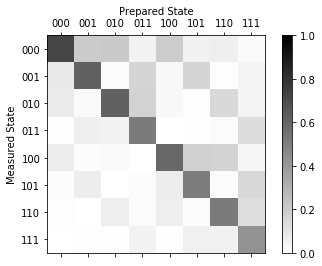

In [9]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

## Analyzing the Results

We would like to compute the total measurement fidelity, and the measurement fidelity for a specific qubit, for example, Q0.

Since the on-diagonal elements of the calibration matrix are the probabilities of measuring state 'x' given preparation of state 'x', 
then the trace of this matrix is the average assignment fidelity.


In [10]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 0.565625
Average Measurement Fidelity of Q0: 0.829875


## Applying the Calibration

We now perform another experiment and correct the measured results. 

## Correct Measurement Noise on a 3Q GHZ State

As an example, we start with the 3-qubit GHZ state on the qubits Q2,Q3,Q4:

$$ \mid GHZ \rangle = \frac{\mid{000} \rangle + \mid{111} \rangle}{\sqrt{2}}$$

In [11]:
# Make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

We now execute the calibration circuits (with the noise model above)

In [12]:
job = qiskit.execute([ghz], backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

We now compute the results without any error mitigation and with the mitigation, namely after applying the calibration matrix to the results.

There are two fitting methods for applying thr calibration (if none method is defined, then 'least_squares' is used). 
- **'pseudo_inverse'**, which is a direct inversion of the calibration matrix, 
- **'least_squares'**, which constrained to have physical probabilities.

The raw data to be corrected can be given in a number of forms:

- Form1: A counts dictionary from results.get_counts,
- Form2: A list of counts of length=len(state_labels),
- Form3: A list of counts of length=M*len(state_labels) where M is an integer (e.g. for use with the tomography data),
- Form4: A qiskit Result (e.g. results as above).

In [13]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

We can now plot the results with and without error mitigation:

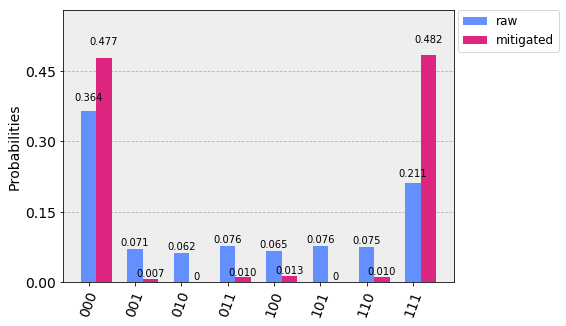

In [14]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

## Tensored mitigation

The calibration can be simplified if the error is known to be local. By "local error" we mean that the error can be tensored to subsets of qubits. In this case, less than $2^n$ states are needed for the computation of the calibration matrix.

Assume that the error acts locally on qubit 2 and the pair of qubits 3 and 4. Construct the calibration circuits by using the function `tensored_meas_cal`. Unlike before we need to explicitly divide the qubit list up into subset regions.

In [12]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
mit_pattern = [[2],[3,4]]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')

We now retrieve the names of the generated circuits. Note that in each label (of length 3), the least significant bit corresponds to qubit 2, the middle bit corresponds to qubit 3, and the most significant bit corresponds to qubit 4.

In [13]:
for circ in meas_calibs:
    print(circ.name)

mcalcal_000
mcalcal_010
mcalcal_101
mcalcal_111


Let us elaborate on the circuit names. We see that there are only four circuits, instead of eight. The total number of required circuits is $2^m$ where m is the number of qubits in the larget subset (here m=2).

Each basis state of qubits 3 and 4 appears exactly once. Only two basis states are required for qubit 2, so these are split equally across the four experiments. For example, state '0' of qubit 2 appears in state labels '000' and '010'.

We now execute the calibration circuits on Aer simulator, using the same noise model as before. This noise is in fact local to qubits 3 and 4 separately, but assume that we don't know it, and that we only know that it is local for qubit 2.

In [14]:
# Generate a noise model for the 5 qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

In [15]:
# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

In [16]:
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

The fitter provides two calibration matrices. One matrix is for qubit 2, and the other matrix is for qubits 3 and 4.

In [17]:
print(meas_fitter.cal_matrices)

[array([[0.902, 0.235],
       [0.098, 0.765]]), array([[0.8  , 0.219, 0.223, 0.063],
       [0.08 , 0.673, 0.03 , 0.184],
       [0.103, 0.024, 0.676, 0.176],
       [0.017, 0.084, 0.071, 0.577]])]


We can look at the readout fidelities of the individual tensored components or qubits within a set

In [19]:
#readout fidelity of Q2
print('Readout fidelity of Q2: %f'%meas_fitter.readout_fidelity(0))

#readout fidelity of Q3/Q4
print('Readout fidelity of Q3/4 space (e.g. mean assignment '
      '\nfidelity of 00,10,01 and 11): %f'%meas_fitter.readout_fidelity(1))

#readout fidelity of Q3
print('Readout fidelity of Q3: %f'%meas_fitter.readout_fidelity(1,[['00','10'],['01','11']]))

Readout fidelity of Q2: 0.833500
Readout fidelity of Q3/4 space (e.g. mean assignment 
fidelity of 00,10,01 and 11): 0.681500
Readout fidelity of Q3: 0.830000


Plot the individual calibration matrices

Q2 Calibration Matrix


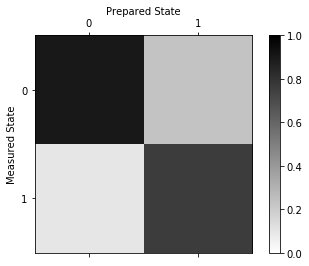

Q3/Q4 Calibration Matrix


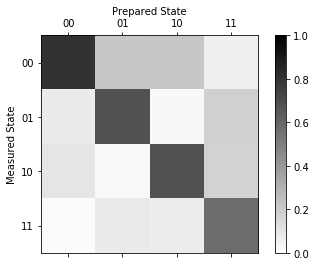

In [20]:
# Plot the calibration matrix
print('Q2 Calibration Matrix')
meas_fitter.plot_calibration(0)
print('Q3/Q4 Calibration Matrix')
meas_fitter.plot_calibration(1)

In [21]:
# Make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

We now execute the calibration circuits (with the noise model above)

In [22]:
job = qiskit.execute([ghz], backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

In [23]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

Plot the raw vs corrected state

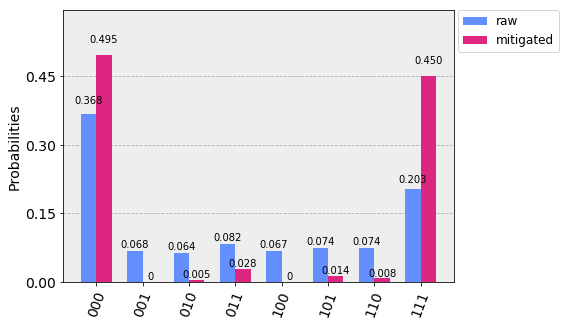

In [24]:
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

As a check we should get the same answer if we build the full correction matrix from a tensor product of the subspace calibration matrices

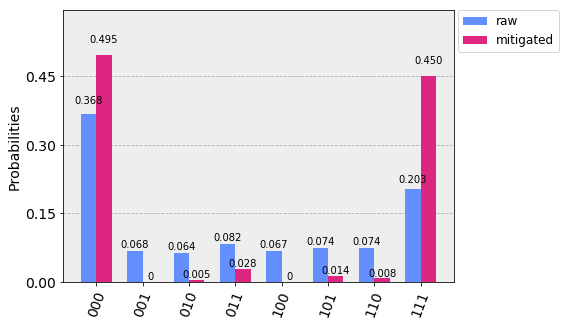

In [25]:
meas_calibs2, state_labels2 = complete_meas_cal([2,3,4])
meas_fitter2 = CompleteMeasFitter(None, state_labels2)
meas_fitter2.cal_matrix = np.kron(meas_fitter.cal_matrices[1],meas_fitter.cal_matrices[0])
meas_filter2 = meas_fitter2.filter
mitigated_results2 = meas_filter2.apply(results)
mitigated_counts2 = mitigated_results2.get_counts(0)
plot_histogram([raw_counts, mitigated_counts2], legend=['raw', 'mitigated'])